# <center><a href='https://mybinder.org/v2/gh/fortierq/itc-binder/main?urlpath=git-pull%3Frepo%3Dhttps%253A%252F%252Fgithub.com%252Ffortierq%252Fnotebooks%26urlpath%3Dlab%252Ftree%252Fnotebooks%252Fnb%252Fmachine_learning%252Fvoitures%252Fvoitures_clustering.ipynb%26branch%3Dmaster'>Clustering de voitures <img src=https://mybinder.org/badge.svg></a></center>

Ce notebook est un exemple de clustering de données. Nous souhaitons diviser des voitures en plusieurs groupes. Commençons par regarder les données.

## Aperçu des données

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook"

In [71]:
data = pd.read_excel("voitures_clustering.xlsx")
data.T

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
Modele,PANDA,TWINGO,YARIS,CITRONC2,CORSA,FIESTA,CLIO,P1007,MODUS,MUSA,...,P307CC,PTCRUISER,MONDEO,MAZDARX8,VELSATIS,CITRONC5,P607,MERC_E,ALFA 156,BMW530
puissance,54,60,65,61,70,68,100,75,113,100,...,180,223,145,231,150,210,204,204,250,231
cylindree,1108,1149,998,1124,1248,1399,1461,1360,1598,1910,...,1997,2429,1999,1308,2188,2496,2721,3222,3179,2979
vitesse,150,151,155,158,165,164,185,165,188,179,...,225,200,215,235,200,230,230,243,250,250
longueur,354,344,364,367,384,392,382,374,380,399,...,435,429,474,443,486,475,491,482,443,485
largeur,159,163,166,166,165,168,164,169,170,170,...,176,171,194,177,186,178,184,183,175,185
hauteur,154,143,150,147,144,144,142,161,159,169,...,143,154,143,134,158,148,145,146,141,147
poids,860,840,880,932,1035,1138,980,1181,1170,1275,...,1490,1595,1378,1390,1735,1589,1723,1735,1410,1495
C02,135,143,134,141,127,117,113,153,163,146,...,210,235,189,284,188,238,223,183,287,231


L'histogramme de chaque paramètre donne des indications sur sa répartition :

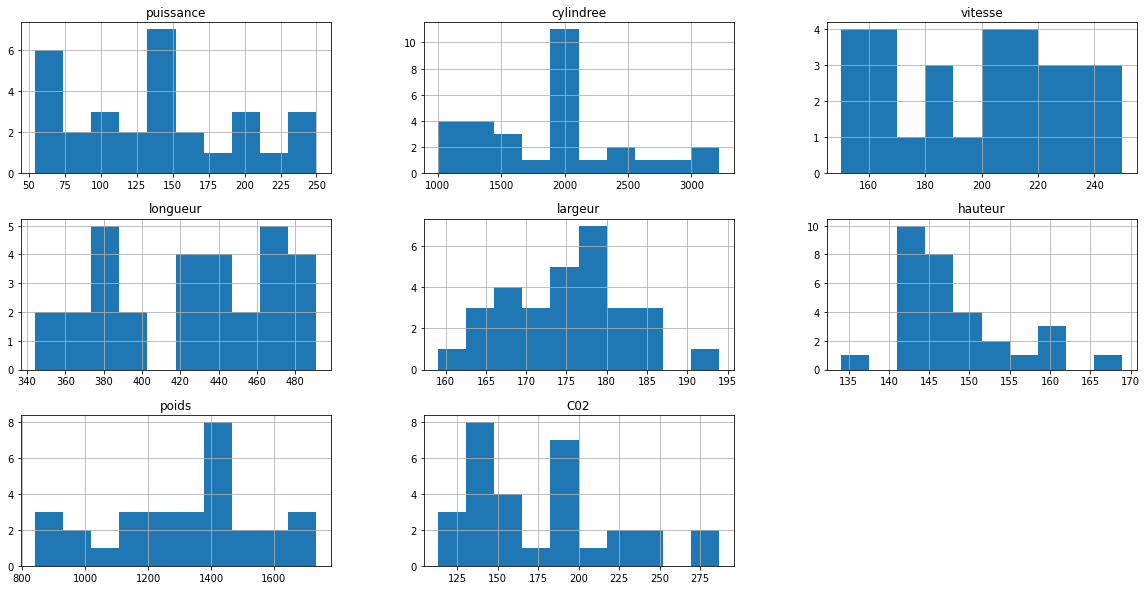

In [70]:
data.hist(bins=10, figsize=(20, 10));

Pour utiliser un algorithme de machine learning, il est toujours conseillé de standardiser les données.

In [45]:
from sklearn import preprocessing

data_scaled = preprocessing.scale(data.iloc[:, 1:])  # standardisation

## Réduction de la dimension par PCA

Pour visualiser les données, nous allons utiliser une analyse par composantes principales (PCA), permettant de réduire le nombre de dimensions (ici, de 9 à 2) : 

In [80]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
data2d = pd.DataFrame(pca.fit_transform(data_scaled), index=data["Modele"], columns=["x", "y"])
pca.explained_variance_ratio_ # variance expliquée par les deux axes principaux

array([0.70547537, 0.13780777])

Le pourcentage de variance expliquée par les deux axes principaux est environ 0.84, ce qui permet donc de conserver beaucoup d'information.

In [81]:
pd.DataFrame(pca.components_, index=["x", "y"], columns=data.columns[1:])  # coordonnées des deux axes principaux

,puissance,cylindree,vitesse,longueur,largeur,hauteur,poids,C02
x,-0.393466,-0.364012,-0.400973,-0.386224,-0.348839,0.120983,-0.384690,-0.344120
y,-0.099743,0.240731,-0.113762,0.060612,0.153163,0.868122,0.282546,-0.241984


On voit que l'axe x discrimine les grosses voitures : plus cette valeur est petite, plus la voiture correspondante est puissante, rapide, large, polluante... Étonnamment, la hauteur rentre peu en compte sur cet axe et est même inversement proportionnelle aux autre coordonnées.  
L'axe y discrimine les voitures selon leur hauteur principalement.  
Il y a donc 2 informations particulièrement importantes : la largeur générale de la voiture et sa hauteur.  

In [85]:
fig = px.scatter(x=data2d.iloc[:, 0], y=data2d.iloc[:, 1], text=data2d.index)
fig.update_traces(textposition='top center')
fig.show()

## Clustering avec K-Means

Puisque nous ne connaissons pas à l'avance les labels/groupes, nous allons utiliser un algorithme de clustering. L'un des plus connus est K-Means. Comme K-Means dépend largement de la position des centroïdes initiaux, nous l'exécutons plusieurs fois en conservant le meilleur (i.e. avec l'inertie la plus faible) :  

In [75]:
def kmeans_multiple(data, k, n):
    km_best = KMeans(n_clusters=k).fit(data)
    for _ in range(n - 1):
        km = KMeans(n_clusters=k).fit(data)
        if km.inertia_ < km_best.inertia_:
            km_best = km
    return km_best

Pour choisir le nombre de clusters $k$, on peut dessiner l'inertie en fonction du nombre de clusters.

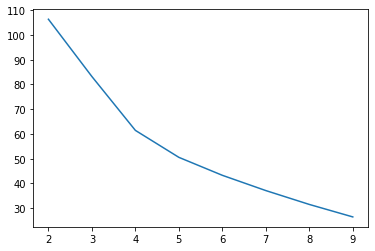

In [76]:
from sklearn.cluster import KMeans

X, Y = [], []
for k in range(2, 10):
    km = kmeans_multiple(data_scaled, k, 20)
    Y.append(km.inertia_)
    X.append(k)
plt.plot(X, Y);

On choisit $k$ comme le nombre de clusters à partir duquel l'inertie stagne (*elbow method*), ici 5 par exemple (on pourrait aussi raisonnablement choisir 4).  
**Remarque** : on pourrait aussi utiliser la méthode par *silhouette analysis*.

In [78]:
km = kmeans_multiple(data_scaled, 5, 20)

In [84]:
fig = px.scatter(x=data2d.iloc[:, 0], y=data2d.iloc[:, 1], text=data2d.index, color=list(map(str, km.labels_)))
fig.update_traces(marker=dict(size=12), textposition='top center')
fig.update_layout(title_text='Données suivant les deux composantes principales du PCA')
fig.show()

In [55]:
data.groupby(km.labels_) \
    .mean()  # moyenne des caractéristiques des voitures de chaque cluster

,puissance,cylindree,vitesse,longueur,largeur,hauteur,poids,C02
0,240.500000,2243.500000,242.500000,443.000000,176.000000,137.500000,1400.000000,285.500000
1,144.600000,1926.700000,212.000000,451.200000,179.400000,144.500000,1379.200000,180.100000
2,68.285714,1212.428571,161.142857,369.571429,164.428571,146.285714,952.142857,130.000000
3,203.666667,2672.500000,225.500000,474.666667,181.166667,149.666667,1645.333333,216.333333
4,100.600000,1765.400000,179.200000,391.600000,172.400000,159.600000,1236.600000,149.200000


On peut aussi appliquer des classifications *one vs all* à l'aide de regressions logistiques pour regarder les coefficients de classification, c'est à dire ce qui permet de discriminer chaque classe : 

In [56]:
from sklearn.linear_model import LogisticRegression

rows = []
for i in range(km.n_clusters):
    t = np.where(km.labels_ == i)[0]
    y = np.zeros((len(data.index)))
    y[t] = 1
    lr = LogisticRegression(max_iter = 4000).fit(data.iloc[:, 1:], y)
    rows.append(lr.coef_[0])

pd.DataFrame(rows, columns=data.columns[1:])

,puissance,cylindree,vitesse,longueur,largeur,hauteur,poids,C02
0,0.076320,-0.001423,0.030741,-0.028968,-0.003793,-0.009719,-0.029566,0.142163
1,-0.531364,-0.012197,0.932353,0.116072,-0.117748,-1.069689,0.026059,-0.018776
2,-0.071782,-0.018595,0.052172,0.188986,0.079396,0.041197,-0.038762,-0.186173
3,0.214947,0.010016,-0.233283,0.047294,-0.254580,-0.219629,0.057672,-0.202794
4,-0.368794,0.023960,-0.007900,-0.514661,0.203545,0.417526,0.073590,0.099268


## Conclusion

Ainsi on distingue :  
- Groupe 0 : voitures sportives. Puissante, rapide, polluante, plutôt basse. Exemple : Alfa Romeo 156.
- Groupe 1 : voitures "normales". Exemple : Laguna.
- Groupe 2 : citadines. Peu puissante, petite, légère, faible consommation. Exemple : Twingo.
- Groupe 3 : grosse voiture type SUV. Lourde, polluante, puissante. Exemple : C5.
- Groupe 4 : voiture familiale/petit monospace. Haute, peu rapide. Exemple : Modus.